## Elementos finitos linear 1D

## Montar a matrix de massa

In [75]:
using Jacobi

## Funções

In [76]:
remap(x,a,b) = ((1-x)*a + (1+x)*b)/2

remap (generic function with 1 method)

In [77]:
function ψj(p,E,Q)
    if(p == 1)
     return  (1-E)/2
        elseif(p == 2)
     return  (1+E)/2
    else
     return  (1-E)*(1+E)/4 .* jacobi(E, p-3, 1, 1)
    end
end 

ψj (generic function with 1 method)

In [78]:
function dψj(p,E,Q)
    if(p == 1)
     return  (-1)/2
        elseif(p == 2)
     return  (1)/2
    else
        return  -E/2 *jacobi(E, p-3, 1, 1) + (1+E)*(1-E)/4 * djacobi(E,p-3,1,1)
    end
end 

dψj (generic function with 1 method)

In [79]:
function  ϕ_matrix(ψj,Q,M)
    ϕ = zeros(Q,M)
    ξ = zglj(Q)
    for i in 1:M
        for j in 1:Q
            ϕ[j,i] = ψj(i,ξ[j],M)
        end
    end
  return ϕ
end

ϕ_matrix (generic function with 1 method)

In [80]:
function  ϕ_matrix_interp(ψj,Q,M)
    ϕ = zeros(Q,M)
    ξ = linspace(-1,1,Q)
    for i in 1:M
        for j in 1:Q
            ϕ[j,i] = ψj(i,ξ[j],M)
        end
    end
  return ϕ
end

ϕ_matrix_interp (generic function with 1 method)

In [81]:
function Me_matrix(ϕ,w,M,Q,a,b)
    L = zeros(M,M)
    jac = (b-a)/2
    for i in 1:M
        for j in 1:M
           m= 0.0
            for q in 1:Q
                m = m + ϕ[q,i]*ϕ[q,j]*w[q]*jac
            end
            L[i,j] = m
        end
    end
    return L
end

Me_matrix (generic function with 1 method)

In [82]:
function Se_matrix(ϕ,w,M,Q,a,b)
    L = zeros(M,M)
    jac = (b-a)/2
    for i in 1:M
        for j in 1:M
           m= 0.0
            for q in 1:Q
                m = m + ϕ[q,i]*ϕ[q,j]*w[q]*jac^-1
            end
            L[i,j] = m
        end
    end
    return L
end

Se_matrix (generic function with 1 method)

### $ϕ$ e  matriz de massa

In [83]:
Nel = 5
I = 5
nb = Nel + 1
ni = (I-2)
Q = I+2

#indices locais
ib = collect(1:2)
ii = collect(3:I)

#limites
a = -1; 
b = 1;
#problema
fun(x) = (1.0 - 4*pi^2)*sin(2*pi*x) 
resp(x) = sin(2*pi*x)
cond_dir = [0.0,0.0]

z = zglj(Q)
w = wglj(z)
ϕ = ϕ_matrix(ψj,Q,I);
dϕ = ϕ_matrix(dψj,Q,I)
xn = [linspace(a,b,Nel+1);];
X = zeros(Q,Nel)
remap(x,a,b) = ((1-x)*a + (1+x)*b)/2
for e in 1:Nel
    X[:,e] = [remap(x,xn[e],xn[e+1]) for x in z]
end
X;

In [84]:

dof_map = zeros(Int, 2, Nel)
for i = 1:Nel
    dof_map[1,i] = i
    dof_map[2,i] = i+1
end
dof_map

2x5 Array{Int64,2}:
 1  2  3  4  5
 2  3  4  5  6

In [85]:

using Base.LinAlg.BLAS.gemm!
using Base.LinAlg.BLAS.gemv!
using Base.LinAlg.LAPACK.potrf!
using Base.LinAlg.LAPACK.potrs!

### $ A_{bb}^* = (A_{bb} - A_{bi} A_{ii}^{-1} A_{ib})  $

In [86]:
dp  = zeros(Nel +1)
dl  = zeros(Nel)
M = Vector{Array{Float64,2}}(Nel)
Mii = Vector{Array{Float64,2}}(Nel)
for e in 1:Nel
    Me = Me_matrix(ϕ, w, I, Q, xn[e], xn[e+1]) ;  #mass matrix
    Se = Se_matrix(dϕ, w, I, Q, xn[e], xn[e+1]) ; #stiff matrix
    Mbb = Me[ib,ib] - Se[ib,ib]
    Mbi = Me[ib,ii] - Se[ib,ii]
    Mib = Me[ii,ib] - Se[ii,ib]
    Mii[e] = Me[ii,ii] - Se[ii,ii]
    
    potrf!('L',Mii[e]); #Mii^-1
    M[e] = copy(Mib)
    potrs!('L',Mii[e],M[e]) # M = Mii^-1 * Mbi
    gemm!('T', 'N', -1.0, M[e], Mib, 1.0, Mbb) # Mbb = -1*M*Mib + Mbb
    
    for i in 1:2
        ig = dof_map[i,e]
        for j in 1:2
            jg = dof_map[j,e]
            if jg == ig #principal
                dp[jg] += Mbb[i,j]
            end
            if jg == ig + 1 && jg > 1#low
              dl[jg-1] += Mbb[i,j] 
            end
        end
    end
end
dp[1],dp[end] = 10^10,10^10
Abb = SymTridiagonal(dp,dl); 
Abb

6x6 SymTridiagonal{Float64}:
 1.0e10    2.56506   0.0       0.0       0.0      0.0    
 2.56506  -4.73673   2.56506   0.0       0.0      0.0    
 0.0       2.56506  -4.73673   2.56506   0.0      0.0    
 0.0       0.0       2.56506  -4.73673   2.56506  0.0    
 0.0       0.0       0.0       2.56506  -4.73673  2.56506
 0.0       0.0       0.0       0.0       2.56506  1.0e10 

In [87]:
fact = ldltfact!(Abb);

## RHS

In [88]:

#calcula F
Fe = zeros(I,Nel)
for e = 1:Nel
    jac = (xn[e+1] - xn[e] )/2
    for i in 1:I
        temp = 0.0
        for q in 1:Q
            temp += fun(X[q,e])* ϕ[q,i] * w[q] * jac
        end
        Fe[i,e] = temp
    end
end
Fe[1,1] = 0; Fe[2,end]= 0;#arrumar

0

In [89]:
Fe = Fe

5x5 Array{Float64,2}:
  0.0        1.20479    2.7424       -5.64209    6.38669 
 -6.38669    5.64209   -2.7424       -1.20479    0.0     
 -2.07552    1.28274   -2.77556e-17  -1.28274    2.07552 
 -0.355435   0.930541  -1.15021       0.930541  -0.355435
  0.302271  -0.186814   0.0           0.186814  -0.302271

### $f_b^* =f_b - A_{bi} A_{ii}^{-1} f_i$

In [90]:
Fb = zeros(nb)

for e in 1:Nel
    fe  = Fe[:,e]
    fb  = fe[ib]
    fi  = fe[ii]
    gemv!('T',-1.0,M[e],fi, 1.0, fb) #fbb = -1*M^T*fi + fb

    for i in 1:2
        ig = dof_map[i,e]
        Fb[ig] += fb[i]
    end

end
Fb;

# Solve   $A^*_{bb}\ u_b =\ f^*_b$

In [91]:
Ue = zeros(I,Nel)

#potrs!('L',Abb,Fb)
Ub = fact\Fb


6-element Array{Float64,1}:
 -1.38135e-10
  0.578174   
 -0.935505   
  0.935505   
 -0.578174   
  1.38135e-10

### $u_i = A_{ii}^{-1}f_i - A_{ii}^{-1} A_{bi}^t u_b$

In [92]:
U = zeros(I,Nel)
for e in 1:Nel
    ub  = Ub[vec(dof_map[:,e])]
    fe  = Fe[:,e]
    fi  = fe[ii]

    potrs!('L',Mii[e],fi)
    gemv!('N',-1.0,M[e],ub,1.0,fi) #fi = -1*M*ub + fi
    
    U[ib,e] = ub
    U[ii,e] = fi
end
U 

5x5 Array{Float64,2}:
 -1.38135e-10   0.578174   -0.935505      0.935505   -0.578174   
  0.578174     -0.935505    0.935505     -0.578174    1.38135e-10
 -3.1155        1.92549     7.63278e-17  -1.92549     3.1155     
 -0.0914817     0.239502   -0.296041      0.239502   -0.0914817  
  0.0300701    -0.0185844  -9.48677e-20   0.0185844  -0.0300701  

In [93]:
Uh = zeros(Q,Nel)
for e in 1:Nel
    Uh[:,e] = ϕ*U[:,e]
end
Uh

7x5 Array{Float64,2}:
 -1.38135e-10   0.578174  -0.935505      0.935505  -0.578174   
 -0.176853      0.565715  -0.738493      0.629192  -0.279561   
 -0.436948      0.507662  -0.384466      0.114418   0.199335   
 -0.495427      0.306191   6.85234e-16  -0.306191   0.495427   
 -0.199335     -0.114418   0.384466     -0.507662   0.436948   
  0.279561     -0.629192   0.738493     -0.565715   0.176853   
  0.578174     -0.935505   0.935505     -0.578174   1.38135e-10

In [94]:
using PyPlot

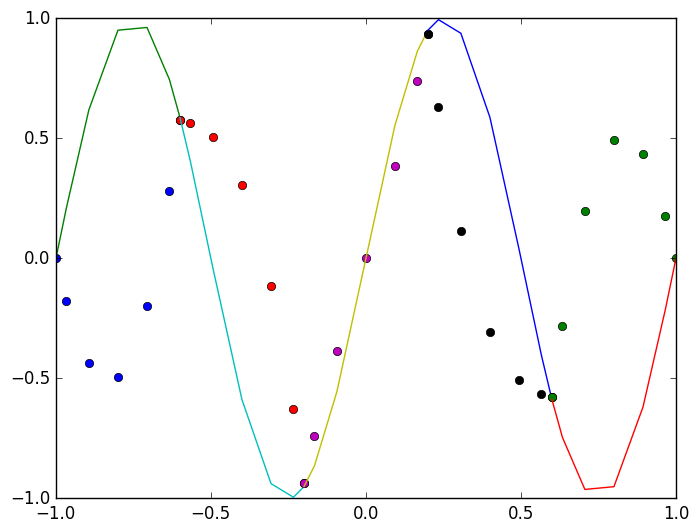

In [95]:

for e in 1:Nel
    plot(X[:,e],Uh[:,e],"o")
    y = [fun(x) for x in X[:,e] ]
    plot(X[:,e],[resp(x) for x in X[:,e] ])
    #legend()
end


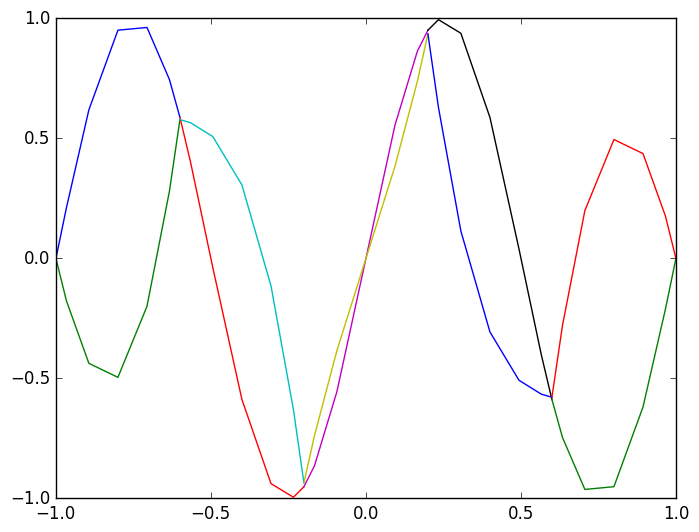

In [96]:

for e in 1:Nel
    plot(X[:,e],[resp(x) for x in X[:,e] ])
    plot(X[:,e],Uh[:,e])
end


In [97]:
Ue = resp(X)
erro = Uh - Ue
Ndof = nb + Nel*(ni)
Ndof,maxabs(erro)

(21,1.4464838302449463)